In [36]:
import gerrychain
from gerrychain import (
    MarkovChain,
    constraints,
    accept,
    GeographicPartition,
    updaters
)
from gerrychain.proposals import recom
from gerrychain.tree import recursive_seed_part, bipartition_tree, recursive_tree_part
from functools import partial
from tqdm import tqdm
import pandas as pd
import os
import click
import random
from division_aware import *
import matplotlib.pyplot as plt
from utilities import *

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
graph = Graph.from_file("shapes/MA_precincts_02_10.shp")
munis, nodes_by_muni = get_divisions(graph, "TOWN")
counties, nodes_by_county = get_divisions(graph, "COUNTYFP10")

/root/anaconda3/envs/gerrychain/lib/python3.8/site-packages/gerrychain/graph/graph.py:238: UserWarning: Found islands (degree-0 nodes). Indices of islands: {62, 55}
  warnings.warn(
/root/anaconda3/envs/gerrychain/lib/python3.8/site-packages/gerrychain/graph/graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [67]:
epsilon = 0.02
steps = 1000
first_check_division = False
division_aware = False
tuple_type = "BOTH_EQUAL"
POP_COL = "TOTPOP"
existing_partition = "CD10"

In [68]:
my_updaters = {"population": updaters.Tally(POP_COL, alias="population")}
initial_partition = GeographicPartition(graph, assignment=existing_partition, updaters=my_updaters)
total_population = sum(initial_partition["population"].values())

num_dists = 9
epsilon = .02

pop_target = total_population / num_dists
result = recursive_seed_part(graph, 
                             range(num_dists), 
                             pop_target, 
                             POP_COL, 
                             epsilon, 
                             method=bipartition_tree, 
                             n = None, 
                             ceil = None)

recursive_partition_2010 = GeographicPartition(graph, result, updaters=my_updaters)

In [69]:
if tuple_type == "COUNTYFP10" or tuple_type == "TOWN":
    division_tuples = [(tuple_type, 1)]
elif tuple_type == "BOTH_EQUAL":
    division_tuples = [("COUNTYFP10", 1), ("TOWN", 1)]
elif tuple_type == "COUNTY_PREF":
    division_tuples = [("COUNTYFP10", 2), ("TOWN", 1)]
elif tuple_type == "MUNI_PREF":
    division_tuples = [("COUNTYFP10", 1), ("TOWN", 2)]
else:
    raise ValueError("ERROR: `tuple_type` needs to be one of 'COUNTYFP10', 'TOWN', 'BOTH_EQUAL', 'COUNTY_PREF', or 'MUNI_PREF'.")
    
def L1(vec):
    return sum(abs(v) for v in vec)

def guided_acceptance_factory(elections):

    def accept_more_proportional(partition):
        parent = partition.parent
        child_v = proportionality_vector(partition, elections)
        parent_v = proportionality_vector(parent, elections)
        child_score = L1(child_v)
        parent_score = L1(parent_v)
        probability = min([1*math.exp(180*(parent_score - child_score)), 1])
        if random.random() < probability:
            return True
        else:
            return False
    return accept_more_proportional

# initial_partition = make_partition_from_districtr_csv("MA", graph, "MA1", unit_col='NAME10')
ideal_population = sum(initial_partition.population.values()) / len(initial_partition)
if division_aware:
    proposal = partial(recom,
                       pop_col = POP_COL,
                       pop_target = ideal_population,
                       epsilon = epsilon,
                       method = partial(division_bipartition_tree,
                                       division_tuples=division_tuples,
                                       first_check_division = first_check_division),
                       node_repeats = 2)
else:
    proposal = partial(recom,
                       pop_col=POP_COL,
                       pop_target=ideal_population,
                       epsilon=epsilon,
                       node_repeats=2)

elections = states["MA"]["elections"].keys()
acceptance = guided_acceptance_factory(elections)

chain = MarkovChain(
                    proposal = proposal,
                    constraints = [constraints.within_percent_of_ideal_population(initial_partition, epsilon)],
                    accept = accept.always_accept,
                    initial_state = recursive_partition_2010,
                    total_steps = steps)

In [70]:
split_counties = []
split_munis = []
# proportionality_L1s = []
lowest_split_counties = None
lowest_split_munis = None
lowest_split_sum = None
best_plan_counties = None
best_plan_munis = None
best_plan_sum = None
for i, part in enumerate(chain.with_progress_bar()):
    num_split_counties = num_division_splits(graph, part, counties, nodes_by_county, division_col="COUNTYFP10")
    num_split_munis = num_division_splits(graph, part, munis, nodes_by_muni, division_col="TOWN")
#     proportionality_L1 = L1(proportionality_vector(part, elections))
    split_counties.append(num_split_counties)
    split_munis.append(num_split_munis)
#     proportionality_L1s.append(proportionality_L1)
#     if lowest_split_counties is None or num_split_counties <= lowest_split_counties:
#         lowest_split_counties = num_split_counties
#         best_plan_counties = part
#     if lowest_split_munis is None or num_split_munis <= lowest_split_munis:
#         lowest_split_munis = num_split_munis
#         best_plan_munis = part
#     if lowest_split_sum is None or num_split_counties + num_split_munis <= lowest_split_sum:
#         lowest_split_sum = num_split_counties + num_split_munis
#         best_plan_sum = part

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Split Munis')

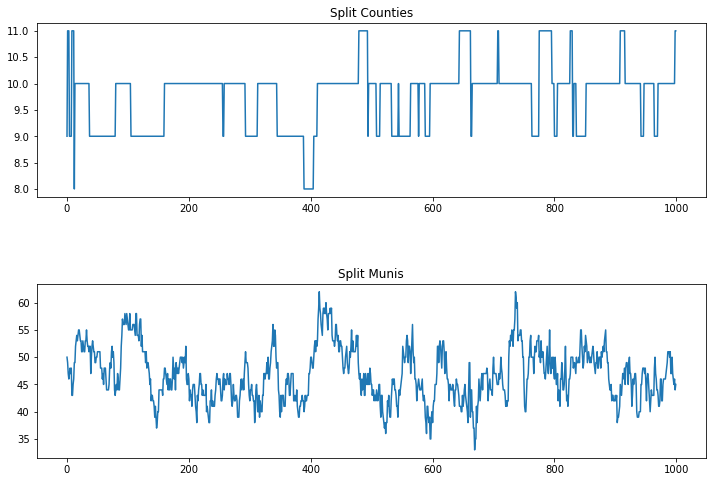

In [71]:
fig, ax = plt.subplots(2,1,figsize=(12,8))
plt.subplots_adjust(hspace=0.5)
ax[0].plot(split_counties)
ax[0].set_title("Split Counties")
ax[1].plot(split_munis)
ax[1].set_title("Split Munis")